<center><img src="https://github.com/DACSS-Spatial/data_forSpatial/raw/main/logo.png" width="700"></center>



<a target="_blank" href="https://colab.research.google.com/github/DACSS-Spatial/binaryOPS/blob/main/index.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Binary Spatial operations on  Geo Dataframes

This time the spatial operations will be applied when we have as input two GDFs.

## Getting ready

The links to the our maps on GitHub are here:

In [2]:
mainLink='https://github.com/meade68/DACSS_690D_Week07/raw/refs/heads/main/'

linkWorldMap=mainLink + "WORLD/worldMaps.gpkg"
linkIndicators=mainLink + "WORLD/worldindicators.json"
linkBrazil=mainLink + "BRAZIL/brazil_5880.gpkg"


Let me introduce another [data source on seaports](https://msi.nga.mil/Publications/WPI). Their locations in long/lat is stored in the file **seaports.csv** which we already have on GitHub:

In [3]:
linkSeaPorts=mainLink + 'WORLD/seaports.csv'

Let's get some maps:

In [5]:
import geopandas as gpd

#world
world_rivers=gpd.read_file(linkWorldMap,layer='rivers')
#brazil
brazil5880=gpd.read_file(linkBrazil,layer='country')
airports_brazil5880=gpd.read_file(linkBrazil,layer='airports')
states_brazil5880=gpd.read_file(linkBrazil,layer='states')
municipalities_brazil5880=gpd.read_file(linkBrazil,layer='municipalities')
#some indicators
indicators=gpd.read_file(linkIndicators)

# the seaports
import pandas as pd
infoseaports=pd.read_csv(linkSeaPorts)

In [6]:
# the sesports data has too manny columns:
len(infoseaports.columns)

108

Let me keep some columns, and turn the DF into a GDF:

In [7]:
#rename
infoseaports.rename(columns={'Main Port Name':'seaport_name','Country Code':'country_name'},inplace=True)

#keep few columns
infoseaports=infoseaports.loc[:,['seaport_name', 'country_name','Latitude', 'Longitude']]

#spatial points (unprojected)
seaports=gpd.GeoDataFrame(data=infoseaports.copy(),
                           geometry=gpd.points_from_xy(infoseaports.Longitude,
                                                       infoseaports.Latitude),
                          crs=4326)# notice it is unprojected

# keep Brazil
seaports_bra=seaports[seaports['country_name']=='Brazil'].copy()

# reset indexes
seaports_bra.reset_index(drop=True, inplace=True)

# reprojecting
seaports_brazil5880=seaports_bra.to_crs(5880) # projected crs

**Before proceeding**, let me compute some GDFs we created the previous session:


* The centroid of Brazil

In [8]:
brazil5880_cen=brazil5880.centroid

- Large Brazilian airports

In [9]:
large_airports=airports_brazil5880.query("airport_type=='large_airport'")

- Amazon Rivers

In [10]:
AmazonSystem=world_rivers.query("SYSTEM=='Amazon'")
AmazonSystem_5880=AmazonSystem.to_crs(5880)

- The states in the East, West, South, and North

In [11]:
mid_x,mid_y=brazil5880_cen.x[0],brazil5880_cen.y[0]

# the north
N_brazil=states_brazil5880.cx[:,mid_y:]
# the south
S_brazil=states_brazil5880.cx[:,:mid_y]
# the west
W_brazil=states_brazil5880.cx[:mid_x,:]
# the east
E_brazil=states_brazil5880.cx[mid_x:,:]

- The mean fragility by region of the world

In [12]:
indicatorsByRegion=indicators.dissolve(
    by="region", #groupby()
    aggfunc={"fragility": "mean"}, #agg()
    )

In [16]:
# You may need to install if using Colab
# !pip install mapclassify


_____________



## I. Distance

Distance is a key binary operation as so many practical policy matters depend on knowing distances between objects in space.

Any pair of rightly projected GDFs have a distance between them. Below we can make  query using distances:

> Which are the airports whose distance to Brazil centroid is > 2500000?

In [17]:
# this is the centroid we have:
brazil5880_cen

0    POINT (5085264.134 8827720.201)
dtype: geometry

Then,

In [18]:
airports_brazil5880[airports_brazil5880.distance(brazil5880_cen[0]) > 2500000]

,airport_name,airport_type,elevation_ft,region,municipality,geometry
4104,Viatec Aviação Agrícola Airport,small_airport,92.0,Rio Grande do Sul,Santa Vitória do Palmar,POINT (5068397.782 6323060.053)
4106,Santa Vitória do Palmar Airport,small_airport,82.0,Rio Grande do Sul,Santa Vitória Do Palmar,POINT (5060939.818 6291358.318)
6662,Trindade Heliport,heliport,NaN,Espírito Santo,Vitória,POINT (7565615.936 7537143.55)


The results can be confirmed visually:

<Axes: >

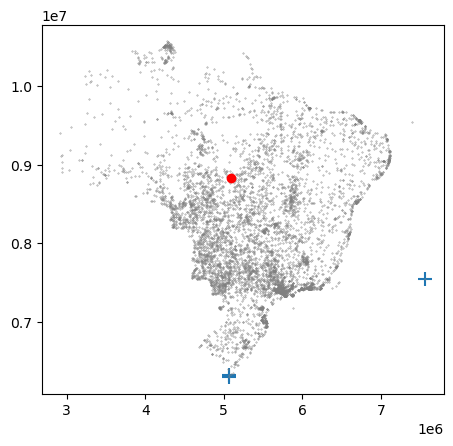

In [19]:
base=airports_brazil5880[airports_brazil5880.distance(brazil5880_cen.iloc[0]) > 2500000].plot(marker='+',markersize=100)
airports_brazil5880.plot(ax=base,color='grey', markersize=0.1)
brazil5880_cen.plot(ax=base,color='red')

Let me review how distances work between different kinds of geometries:

### a.  Distance between points

We have these points:


In [20]:
seaports_brazil5880.head()

,seaport_name,country_name,Latitude,Longitude,geometry
0,Dtse / Gegua Oil Terminal,Brazil,-22.816667,-43.150000,POINT (6112865.27 7434885.819)
1,Porto De Mucuripe,Brazil,-3.716667,-38.483333,POINT (6723610.313 9573897.029)
2,Portocel,Brazil,-19.850000,-40.050000,POINT (6459540.7 7743872.147)
3,Santa Clara,Brazil,-20.883333,-51.366667,POINT (5273988.618 7687595.596)
4,Aratu,Brazil,-12.783333,-38.500000,POINT (6681955.632 8535904.773)


In [21]:
large_airports.head()

,airport_name,airport_type,elevation_ft,region,municipality,geometry
0,Guarulhos - Governador André Franco Montoro In...,large_airport,2461.0,São Paulo,São Paulo,POINT (5769392.959 7387510.487)
1,Rio Galeão – Tom Jobim International Airport,large_airport,28.0,Rio de Janeiro,Rio De Janeiro,POINT (6102623.812 7436387.271)
4,Presidente Juscelino Kubitschek International ...,large_airport,3497.0,Distrito Federal,Brasília,POINT (5651010.181 8235390.09)
5,Deputado Luiz Eduardo Magalhães International ...,large_airport,64.0,Bahia,Salvador,POINT (6700330.807 8520415.591)
9,Tancredo Neves International Airport,large_airport,2721.0,Minas Gerais,Belo Horizonte,POINT (6051718.72 7797008.905)


For results of distance operation to be more insightful, we may do this:

In [22]:
# index will be names of airports/seaports instead of numbers
large_airports.set_index('airport_name',inplace=True)
seaports_brazil5880.set_index('seaport_name',inplace=True)

Notice:

In [23]:
seaports_brazil5880.head()

,country_name,Latitude,Longitude,geometry
seaport_name,,,,
Dtse / Gegua Oil Terminal,Brazil,-22.816667,-43.150000,POINT (6112865.27 7434885.819)
Porto De Mucuripe,Brazil,-3.716667,-38.483333,POINT (6723610.313 9573897.029)
Portocel,Brazil,-19.850000,-40.050000,POINT (6459540.7 7743872.147)
Santa Clara,Brazil,-20.883333,-51.366667,POINT (5273988.618 7687595.596)
Aratu,Brazil,-12.783333,-38.500000,POINT (6681955.632 8535904.773)


In [24]:
large_airports.head()

,airport_type,elevation_ft,region,municipality,geometry
airport_name,,,,,
Guarulhos - Governador André Franco Montoro International Airport,large_airport,2461.0,São Paulo,São Paulo,POINT (5769392.959 7387510.487)
Rio Galeão – Tom Jobim International Airport,large_airport,28.0,Rio de Janeiro,Rio De Janeiro,POINT (6102623.812 7436387.271)
Presidente Juscelino Kubitschek International Airport,large_airport,3497.0,Distrito Federal,Brasília,POINT (5651010.181 8235390.09)
Deputado Luiz Eduardo Magalhães International Airport,large_airport,64.0,Bahia,Salvador,POINT (6700330.807 8520415.591)
Tancredo Neves International Airport,large_airport,2721.0,Minas Gerais,Belo Horizonte,POINT (6051718.72 7797008.905)


> The distance from each airport to the "Dtse / Gegua Oil Terminal"

In [25]:
large_airports.distance(seaports_brazil5880.geometry.loc['Dtse / Gegua Oil Terminal'])

airport_name
Guarulhos - Governador André Franco Montoro International Airport    3.467242e+05
Rio Galeão – Tom Jobim International Airport                         1.035093e+04
Presidente Juscelino Kubitschek International Airport                9.241846e+05
Deputado Luiz Eduardo Magalhães International Airport                1.234298e+06
Tancredo Neves International Airport                                 3.672493e+05
Eduardo Gomes International Airport                                  2.854494e+06
Hercílio Luz International Airport                                   7.681356e+05
Val de Cans/Júlio Cezar Ribeiro International Airport                2.462792e+06
dtype: float64

What about computing...

> All the distances between large aiports and seaports (in km)

In [26]:
# apply creates a LOOP, computes distances from each seaport to all large airports
seaports_brazil5880.geometry.apply\
(lambda seaport: large_airports.geometry.distance(seaport)/1000)

airport_name,Guarulhos - Governador André Franco Montoro International Airport,Rio Galeão – Tom Jobim International Airport,Presidente Juscelino Kubitschek International Airport,Deputado Luiz Eduardo Magalhães International Airport,Tancredo Neves International Airport,Eduardo Gomes International Airport,Hercílio Luz International Airport,Val de Cans/Júlio Cezar Ribeiro International Airport
seaport_name,,,,,,,,
Dtse / Gegua Oil Terminal,346.724171,10.350933,924.184620,1234.297632,367.249276,2854.493600,768.135646,2462.791784
Porto De Mucuripe,2385.543307,2225.886834,1715.246883,1053.738618,1899.676213,2397.739727,2901.295202,1141.963646
Portocel,776.722303,471.101490,946.209008,813.018817,411.269111,2867.979624,1232.521248,2266.253017
Santa Clara,579.203362,865.876382,664.999298,1651.678293,785.388683,2189.659524,805.599343,2185.898767
Aratu,1466.826530,1242.804930,1073.851757,24.032516,971.167168,2609.953079,1975.180167,1690.370196
Cabedelo,2248.124981,2023.173930,1747.914940,786.022123,1751.230863,2830.123680,2757.957782,1641.263825
Imbituba,578.310920,814.278300,1377.148556,2031.882238,1072.105305,3042.768039,63.612808,2983.998277
Angra Dos Reis,225.003606,111.795735,883.019058,1308.028199,380.901616,2791.717379,671.807826,2455.089996
Natal,2341.056650,2128.327377,1799.131283,891.421964,1843.689307,2774.776071,2853.930050,1556.780342


If we save the matrix...

In [27]:
D_Matrix_sea_air=seaports_brazil5880.geometry.apply \
                (lambda seaport: large_airports.geometry.distance(seaport)/1000)

We can compute some distance stats from there:

> Some summary of distances from each seaport to all large airports

In [28]:
Stat_sea_air=pd.DataFrame()
Stat_sea_air['mean']=D_Matrix_sea_air.mean(axis=1) # mean D to all airports
Stat_sea_air['min']=D_Matrix_sea_air.min(axis=1)# min D to all airports
Stat_sea_air['max']=D_Matrix_sea_air.max(axis=1)# max D to all airports

# see some
Stat_sea_air.head(10)

,mean,min,max
seaport_name,,,
Dtse / Gegua Oil Terminal,1121.028458,10.350933,2854.493600
Porto De Mucuripe,1965.136304,1053.738618,2901.295202
Portocel,1223.134327,411.269111,2867.979624
Santa Clara,1216.037957,579.203362,2189.659524
Aratu,1381.773293,24.032516,2609.953079
Cabedelo,1973.226516,786.022123,2830.123680
Imbituba,1495.513055,63.612808,3042.768039
Angra Dos Reis,1103.420427,111.795735,2791.717379
Natal,2023.639130,891.421964,2853.930050


Of course, the idmax and idmin could come in handy:
> Farthest airport to each seaport

In [29]:
D_Matrix_sea_air.idxmax(axis=1).head()

seaport_name
Dtse / Gegua Oil Terminal    Eduardo Gomes International Airport
Porto De Mucuripe             Hercílio Luz International Airport
Portocel                     Eduardo Gomes International Airport
Santa Clara                  Eduardo Gomes International Airport
Aratu                        Eduardo Gomes International Airport
dtype: object

> Farthest seaport to each airport

In [30]:
D_Matrix_sea_air.idxmax(axis=0).head()

airport_name
Guarulhos - Governador André Franco Montoro International Airport    Manaus
Rio Galeão – Tom Jobim International Airport                         Manaus
Presidente Juscelino Kubitschek International Airport                Manaus
Deputado Luiz Eduardo Magalhães International Airport                Manaus
Tancredo Neves International Airport                                 Manaus
dtype: object

> Closest airport to each seaport

In [32]:
D_Matrix_sea_air.idxmin(axis=1).head()

seaport_name
Dtse / Gegua Oil Terminal         Rio Galeão – Tom Jobim International Airport
Porto De Mucuripe            Deputado Luiz Eduardo Magalhães International ...
Portocel                                  Tancredo Neves International Airport
Santa Clara                  Guarulhos - Governador André Franco Montoro In...
Aratu                        Deputado Luiz Eduardo Magalhães International ...
dtype: object

> Closest seaport to each airport


In [33]:
# closest seaport to each airport
D_Matrix_sea_air.idxmin(axis=0).head()

airport_name
Guarulhos - Governador André Franco Montoro International Airport                       Santos
Rio Galeão – Tom Jobim International Airport                         Dtse / Gegua Oil Terminal
Presidente Juscelino Kubitschek International Airport                              Santa Clara
Deputado Luiz Eduardo Magalhães International Airport                         Port De Salvador
Tancredo Neves International Airport                                 Dtse / Gegua Oil Terminal
dtype: object

### b. Distance between line and point

Once we know understand how **distance** and idxmin/idxmax work, we can feel comfortable in this stage.

Let's use these rivers from before:

In [34]:
AmazonSystem_5880.set_index("RIVER",inplace=True)
AmazonSystem_5880

,SYSTEM,geometry
RIVER,,
Amazon,Amazon,"MULTILINESTRING ((4191497.619 9597916.381, 425..."
Guapore,Amazon,"MULTILINESTRING ((3784022.891 8842606.845, 378..."
Japura,Amazon,"MULTILINESTRING ((3782432.967 9748590.005, 382..."
Madeira,Amazon,"MULTILINESTRING ((3784022.891 8842606.845, 378..."
Madre de Dios,Amazon,"MULTILINESTRING ((3407019.812 8246998.613, 343..."
Purus,Amazon,"MULTILINESTRING ((3008899.534 8748725.178, 305..."
Putamayo,Amazon,"MULTILINESTRING ((2478636.973 10162886.59, 246..."
Rio Branco,Amazon,"MULTILINESTRING ((4372657.932 10403233.815, 43..."
Rio Juruena,Amazon,"MULTILINESTRING ((4488340.769 8382801.957, 456..."


Then,
> Distance from river Tapajos to Guarulhos airport

In [35]:
airName='Guarulhos - Governador André Franco Montoro International Airport'
rivName='Tapajos'
AmazonSystem_5880.geometry.loc[rivName].distance(large_airports.geometry.loc[airName])/1000

2170.030197547702

We can compute the distance matrix now:

In [37]:
D_Matrix_amazRivs_air=AmazonSystem_5880.geometry.apply \
                (lambda river: large_airports.geometry.distance(river)/1000)

D_Matrix_amazRivs_air

airport_name,Guarulhos - Governador André Franco Montoro International Airport,Rio Galeão – Tom Jobim International Airport,Presidente Juscelino Kubitschek International Airport,Deputado Luiz Eduardo Magalhães International Airport,Tancredo Neves International Airport,Eduardo Gomes International Airport,Hercílio Luz International Airport,Val de Cans/Júlio Cezar Ribeiro International Airport
RIVER,,,,,,,,
Amazon,2475.774914,2551.736244,1640.038333,1972.201892,2196.772829,25.549158,2865.306190,385.680279
Guapore,1885.212408,2128.037913,1389.142048,2397.410373,1912.669967,983.345006,2057.607164,1828.131144
Japura,2980.961532,3174.069943,2308.103552,3088.311946,2895.025757,502.953032,3214.712005,1801.085954
Madeira,2437.258427,2652.416364,1782.114914,2467.828389,2375.088970,153.127907,2597.378000,1134.676321
Madre de Dios,2375.202840,2672.533506,1963.250807,2934.051647,2497.142251,983.345006,2384.616336,2088.021380
Purus,2644.379897,2848.394230,1965.341923,2709.393257,2556.618662,150.306441,2835.604884,1436.934359
Putamayo,3224.425810,3437.832352,2597.325439,3418.962714,3175.785436,853.437589,3418.665719,2149.442187
Rio Branco,2952.738921,3110.343230,2210.504022,2882.515275,2804.406666,264.452689,3241.167974,1361.024141
Rio Juruena,1622.251468,1871.259070,1135.138781,2139.336751,1667.760083,525.908802,1794.951244,1234.846429


In [38]:
Stat_amz_air=pd.DataFrame()
Stat_amz_air['mean']=D_Matrix_amazRivs_air.mean(axis=1) # mean D to all airports
Stat_amz_air['min']=D_Matrix_amazRivs_air.min(axis=1)# min D to all airports
Stat_amz_air['max']=D_Matrix_amazRivs_air.max(axis=1)# max D to all airports

# see some
Stat_amz_air.head(10)

,mean,min,max
RIVER,,,
Amazon,1764.132480,25.549158,2865.306190
Guapore,1822.694503,983.345006,2397.410373
Japura,2495.652965,502.953032,3214.712005
Madeira,1949.986161,153.127907,2652.416364
Madre de Dios,2237.270472,983.345006,2934.051647
Purus,2143.371707,150.306441,2848.394230
Putamayo,2784.484656,853.437589,3437.832352
Rio Branco,2353.394115,264.452689,3241.167974
Rio Juruena,1498.931579,525.908802,2139.336751


In [39]:
# closest river to each airport
D_Matrix_amazRivs_air.idxmin(axis=0).head()

airport_name
Guarulhos - Governador André Franco Montoro International Airport    Xingu
Rio Galeão – Tom Jobim International Airport                         Xingu
Presidente Juscelino Kubitschek International Airport                Xingu
Deputado Luiz Eduardo Magalhães International Airport                Xingu
Tancredo Neves International Airport                                 Xingu
dtype: object

In [40]:
# farthest river to each airport
D_Matrix_amazRivs_air.idxmax(axis=0).head()

airport_name
Guarulhos - Governador André Franco Montoro International Airport    Rio Maranon
Rio Galeão – Tom Jobim International Airport                         Rio Maranon
Presidente Juscelino Kubitschek International Airport                Rio Maranon
Deputado Luiz Eduardo Magalhães International Airport                Rio Maranon
Tancredo Neves International Airport                                 Rio Maranon
dtype: object

### c. Between Polygon and Point

Let me re use the world rivers to get the rivers in a couple of systems:

In [41]:
river_systems=world_rivers.query("SYSTEM in ['Amazon','Parana']")
river_systems

,RIVER,SYSTEM,geometry
1,Amazon,Amazon,"MULTILINESTRING ((-61.2773 -3.60706, -60.68466..."
24,Guapore,Amazon,"MULTILINESTRING ((-65.1024 -10.27593, -65.1201..."
29,Japura,Amazon,"MULTILINESTRING ((-64.94595 -2.23269, -64.5731..."
37,Madeira,Amazon,"MULTILINESTRING ((-65.1024 -10.27593, -65.0844..."
38,Madre de Dios,Amazon,"MULTILINESTRING ((-68.84791 -15.35547, -68.594..."
55,Paraguay,Parana,"MULTILINESTRING ((-53.47152 -16.67963, -54.309..."
56,Parana,Parana,"MULTILINESTRING ((-58.48091 -27.30186, -58.402..."
59,Purus,Amazon,"MULTILINESTRING ((-72.21624 -10.77936, -71.803..."
60,Putamayo,Amazon,"MULTILINESTRING ((-76.65652 1.36565, -76.77346..."
62,Rio Branco,Amazon,"MULTILINESTRING ((-59.64679 3.62898, -60.19013..."


Let me combine per system:

In [42]:
ama_para=river_systems.dissolve(by='SYSTEM')
ama_para.drop(columns='RIVER',inplace=True)
ama_para

,geometry
SYSTEM,
Amazon,"MULTILINESTRING ((-61.2773 -3.60706, -60.68466..."
Parana,"MULTILINESTRING ((-53.47152 -16.67963, -54.309..."


We still have lines:

<Axes: >

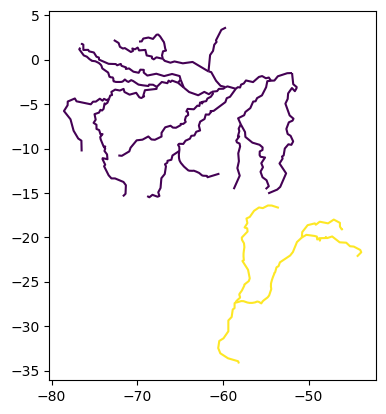

In [43]:
ama_para.plot(cmap='viridis')

But we will have polygons after this:

<Axes: >

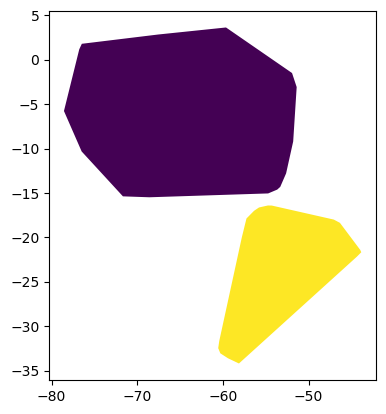

In [44]:
ama_para.convex_hull.plot(cmap='viridis')

As we have a geoseries of two geometries...

In [45]:
ama_para.convex_hull,type(ama_para.convex_hull)

(SYSTEM
 Amazon    POLYGON ((-68.59431 -15.48713, -71.67654 -15.3...
 Parana    POLYGON ((-58.13602 -34.19917, -59.41318 -33.6...
 dtype: geometry,
 geopandas.geoseries.GeoSeries)

Let's turn that into a GDF:

In [46]:
ama_para_hulls=ama_para.convex_hull.to_frame()
ama_para_hulls.rename(columns={0:'geometry'},inplace=True)
ama_para_hulls=ama_para_hulls.set_geometry('geometry')
ama_para_hulls.crs="EPSG:5880"

#voila
ama_para_hulls

,geometry
SYSTEM,
Amazon,"POLYGON ((-68.594 -15.487, -71.677 -15.383, -7..."
Parana,"POLYGON ((-58.136 -34.199, -59.413 -33.614, -6..."


And now, the distance matrix:

In [47]:
D_Matrix_SYSHulls_air=ama_para_hulls.geometry.apply \
                (lambda system: large_airports.geometry.distance(system)/1000)
D_Matrix_SYSHulls_air

airport_name,Guarulhos - Governador André Franco Montoro International Airport,Rio Galeão – Tom Jobim International Airport,Presidente Juscelino Kubitschek International Airport,Deputado Luiz Eduardo Magalhães International Airport,Tancredo Neves International Airport,Eduardo Gomes International Airport,Hercílio Luz International Airport,Val de Cans/Júlio Cezar Ribeiro International Airport
SYSTEM,,,,,,,,
Amazon,9373.464024,9619.902769,9987.801447,10839.402030,9870.020232,10586.985788,8867.621633,11335.110218
Parana,9373.473877,9619.912262,9987.812192,10839.411834,9870.030130,10587.000384,8867.631318,11335.122740


From here, you can compute distances between other kinds of geometries.

## II. Clipping

Clipping uses a GDF geometry as a MASK to cut another GDF which suppossedly is bigger and needes to be clipped.

Pay attention to the world rivers again:

In [48]:
world_rivers

,RIVER,SYSTEM,geometry
0,Aldan,Lena,"MULTILINESTRING ((124.00678 56.47258, 123.2595..."
1,Amazon,Amazon,"MULTILINESTRING ((-61.2773 -3.60706, -60.68466..."
2,Amu Darya,None,"MULTILINESTRING ((73.98818 37.49952, 73.52595 ..."
3,Amur,None,"MULTILINESTRING ((122.63956 49.9973, 120.47874..."
4,Angara,None,"MULTILINESTRING ((105.07841 51.93053, 103.9295..."
...,...,...,...
93,Yangtze,None,"MULTILINESTRING ((119.82609 32.24864, 118.9707..."
94,Yenisey,None,"MULTILINESTRING ((98.94706 52.57675, 98.12095 ..."
95,Yukon,None,"MULTILINESTRING ((-130.89319 59.2448, -131.065..."
96,Zambezi,None,"MULTILINESTRING ((35.52866 -17.66773, 36.28055..."


As you see, this GDF has no Country column. But since it has geometry, you can keep the rivers, or their sections, that serve a country:

In [49]:
rivers_brazil5880 = gpd.clip(gdf=world_rivers.to_crs(5880),
                             mask=brazil5880)

See differences:

- input 1: Rivers

<Axes: >

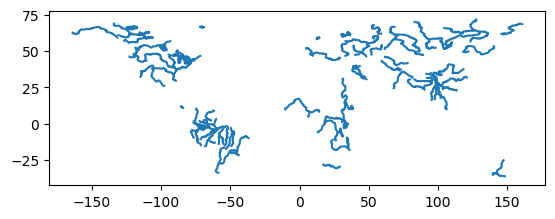

In [50]:
world_rivers.plot()

- input 2: mask (Brazil)

<Axes: >

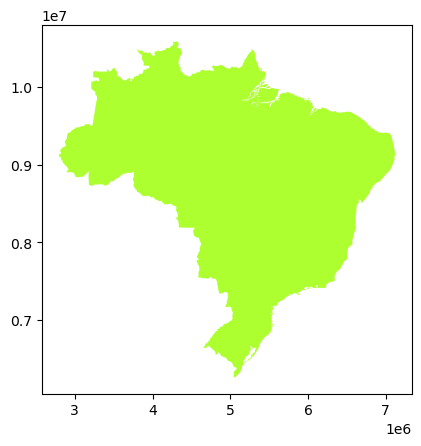

In [51]:
brazil5880.plot(facecolor="greenyellow")

> Output: clipped rivers

<Axes: >

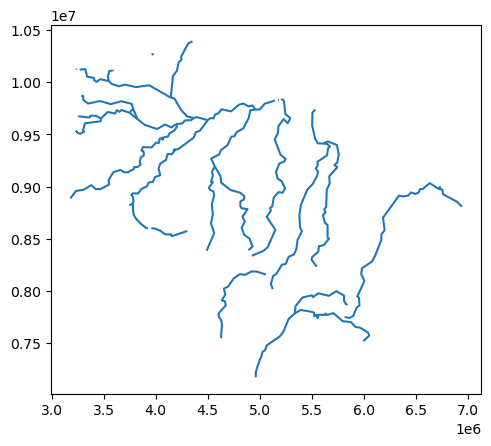

In [52]:
rivers_brazil5880.plot()

<Axes: >

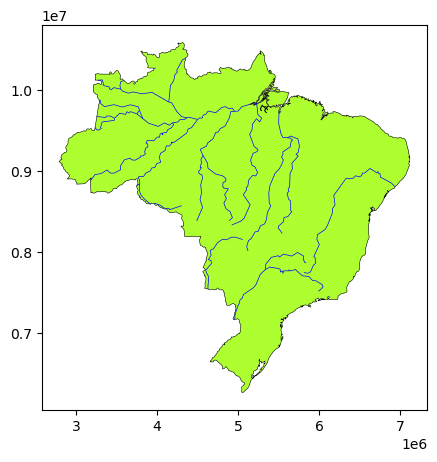

In [53]:
base = brazil5880.plot(facecolor="greenyellow", edgecolor='black', linewidth=0.4,figsize=(5,5))
rivers_brazil5880.plot(edgecolor='blue', linewidth=0.5,
                    ax=base)

We can create our own mask for clipping:

Let me get the **bounding box** of the map (the smallest possible rectangle that completely encloses a geometric shape or set of shapes):

In [54]:
brazil5880.total_bounds #[minx, miny, maxx, maxy]

array([ 2793074.63914733,  6264891.06203913,  7120881.08835731,
       10586462.14322563])

In [55]:
# saving the output
minx, miny, maxx, maxy=brazil5880.total_bounds
minx, miny, maxx, maxy

(np.float64(2793074.6391473296),
 np.float64(6264891.0620391285),
 np.float64(7120881.088357305),
 np.float64(10586462.143225627))

I will combine those coordinates with the _centroid_ (mid_x,mid_y)to create a BOX of the north and south of Brazil:

<Axes: >

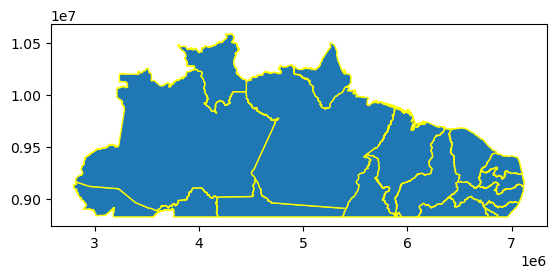

In [56]:
north_mask = [minx, mid_y, maxx, maxy]
south_mask = [minx, minx, maxx, mid_y]

# split Brazil
states_brazil5880.clip(north_mask).plot(edgecolor="yellow")

In [ ]:
states_brazil5880.clip(south_mask).plot(edgecolor="yellow")

As you see, with clip we can cut polygons (not respecting the borders).

## III. Spatial Joins

We’re familiar with **merging**, which joins tables using common keys. Spatial joins, by contrast, rely solely on **geometry columns** to perform various types of filtering.

Let me use the brazilian large airports and states:

In [ ]:
large_airports.head()

...and:

In [ ]:
states_brazil5880.head()

In [ ]:
# as before set index for 'states'
states_brazil5880.set_index('state_name',inplace=True)
states_brazil5880.head()

### a. Within

Let's ask:
> The large airports whose geometries are within the borders of a state in Brazil.

In [ ]:
airports_within_states = gpd.sjoin(
    large_airports,         # LEFT: airports we want to filter/keep
    states_brazil5880,      # RIGHT: spatial boundaries to check against
    how='inner',            # return geometries that match in both LEFT/RIGHT (jointype)
    predicate='within'      # spatial condition: LEFT geometry within RIGHT geometry
)

# these are:
airports_within_states

We just performed a point-to-polygon spatial join.
Notice that the result preserves the original geometries from the LEFT GeoDataFrame — specifically, only those features whose spatial relationship satisfied both the predicate (e.g., 'within') and the join type ('inner').
The non-geometric attributes (columns) from the RIGHT GeoDataFrame are joined to the matching rows.

Notice that, the request gave you points. I will add all the states below:

In [ ]:
base=states_brazil5880.explore(edgecolor='black',style_kwds={'fillOpacity': 0.1,'color':'grey'})
airports_within_states.explore(color='red',m=base)

### b. Contains

Importantly, if the LEFT GeoDataFrame geometries are polygons and the RIGHT one points (a polygon-to-point join), you’ll typically need to use a different predicate — such as 'contains' — to express the spatial relationship correctly.

> Brazilian states that house large airports

In [ ]:
states_containing_LargeAirports = gpd.sjoin(states_brazil5880,large_airports,how='inner',
                                            predicate='contains')

states_containing_LargeAirports

As requested, you got polygons (not the airports). I will add airports for reference.

In [ ]:
base=states_containing_LargeAirports.explore(color='red')
large_airports.explore(color='white',m=base)

### c. Intersects

'Contains' and 'within' are literally strict: Any airport located exactly on a state boundary — whether due to data precision, snapping, or real geography — will be excluded, even if it’s “practically” inside the state. More flexibility is achieved with **intersects**.

> A point on the border of Rio de Janeiro, can be detected if I use intersect!

In [ ]:
# this is RDJ:
Rio=states_brazil5880.loc[['Rio de Janeiro'],:]

#this a point on its border
from shapely.geometry import Point

coordinates=Rio.geometry.iloc[0].boundary.geoms[0].coords[1]
aRDJ_PointInBorder=Point(coordinates)
aRDJ_borderPoint = gpd.GeoDataFrame({'name': ['RioJaneiro Border Point']},
                                    geometry=[aRDJ_PointInBorder],
                                    crs=states_brazil5880.crs)

In [ ]:
## Intersects result
gpd.sjoin(aRDJ_borderPoint,Rio,
          how='inner', predicate='intersects')

> A point on the border of Rio de Janeiro, can NOT be detected if I use within / contains

In [ ]:
## within should return no rows
gpd.sjoin(aRDJ_borderPoint,Rio,
          how='inner', predicate='within')

In [ ]:
## contains should return no rows
gpd.sjoin(Rio,aRDJ_borderPoint,
          how='inner', predicate='contains')

We knew this:

In [ ]:
# we need crs4326 for explore:
aRDJ_borderPoint_latlon = aRDJ_borderPoint.to_crs(4326).geometry.iloc[0]

base=Rio.explore(zoom_start=20,location=[aRDJ_borderPoint_latlon.y, aRDJ_borderPoint_latlon.x])
aRDJ_borderPoint.explore(m=base, color='red')

### d. Touches

We also have 'touches', a more stringent predicate than 'intersects'. It returns geometries that:
 - Share a only a border (for polygons or lines), or
 - Have only one tangent point in common.

> Which states are neighbors of 'BAHIA", including BAHIA

In [ ]:
# Neighbors of Bahia?
gpd.sjoin(N_brazil.loc[N_brazil.state_name=='Bahia',:],N_brazil,how='inner', predicate='intersects').shape

That is, Bahia seems to share borders with 5 states:

In [ ]:
base=gpd.sjoin(N_brazil,N_brazil.loc[N_brazil.state_name=='Bahia',:],
               how='inner',
               predicate='intersects').plot(color='yellow',edgecolor='red')
N_brazil.loc[N_brazil.state_name=='Bahia',:].plot(ax=base, color='red')

However, because many free GeoDataFrames — especially those sourced as Shapefiles — contain topological imperfections like gaps, overlaps, or misaligned vertices, 'touches' often fails to detect what should be adjacent features. Ironically, this “failure” can be useful: 'touches' acts as a diagnostic tool — highlighting where boundaries are not perfectly aligned.

In [ ]:
gpd.sjoin(N_brazil.loc[N_brazil.state_name=='Bahia',:],N_brazil,how='inner', predicate='touches').shape

See the neighbor that disappears:

In [ ]:
base=gpd.sjoin(N_brazil,N_brazil.loc[N_brazil.state_name=='Bahia',:],
               how='inner',
               predicate='touches').plot(color='yellow',edgecolor='red')
N_brazil.loc[N_brazil.state_name=='Bahia',:].plot(ax=base, color='red')

### e. Crosses

When we have **lines**, we may need **crosses**. Let me subset our rivers:

In [ ]:
amazonSystem=rivers_brazil5880[rivers_brazil5880.SYSTEM=='Amazon']
amazonSystem.set_index('RIVER',inplace=True)

Then,
> Which rivers from the Amazon system are intersecting states?

In [ ]:
gpd.sjoin(amazonSystem,states_brazil5880,how='inner', predicate='intersects')

A count of the result:

In [ ]:
gpd.sjoin(amazonSystem,states_brazil5880,how='inner', predicate='intersects').shape

Alternatively,

> Which rivers from the Amazon system are crossing states?

In [ ]:
gpd.sjoin(amazonSystem,states_brazil5880,how='inner', predicate='crosses')

You got one less:

In [ ]:
gpd.sjoin(amazonSystem,states_brazil5880,how='inner', predicate='crosses').shape

Again, _intersects_ means both geometries have some 'space' in common. But **crosses** is an intersection that has to cross the spatial object. From the result above, there is one river that shares space with the state, but is not crossing its border:

In [ ]:
# Get intersects result
intersects_result = gpd.sjoin(amazonSystem,states_brazil5880, how='inner', predicate='intersects')
intersects_result

In [ ]:
# Get crosses result
crosses_result = gpd.sjoin(amazonSystem,states_brazil5880, how='inner', predicate='crosses')
crosses_result

In [ ]:
river_notCrossing=list(set(intersects_result.index)-set(crosses_result.index))
river_notCrossing

In [ ]:
# Find indexes/columns
state_notCrossed=intersects_result.loc[river_notCrossing,'state_name'].to_list()
state_notCrossed

Now we know the river that is not crossing an state, and the name of that state.

In [ ]:
base=states_brazil5880.loc[state_notCrossed,:].plot(color='w',edgecolor='k',figsize=(12, 8))
amazonSystem.plot(ax=base)
amazonSystem.loc[river_notCrossing,:].plot(color='red',ax=base)


## IV. Spatial Overlay

As the name implies, you need two inputs. We might need to create or find some geometries from the geometries we already have. Using a set theory approach, we will see the use of _intersection_, _union_, _difference_, and _symmetric difference_.
Let's remember these results:

In [ ]:
# Create a figure and a 2x2 grid of axes
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes = axes.flatten()

N_brazil.plot(color='pink',edgecolor='k',ax=axes[0])
axes[0].set_title("1. North")

S_brazil.plot(color='pink',edgecolor='k',ax=axes[1])
axes[1].set_title("2. South")

W_brazil.plot(color='pink',edgecolor='k',ax=axes[2])
axes[2].set_title("3. West")

E_brazil.plot(color='pink',edgecolor='k',ax=axes[3])
axes[3].set_title("4. East")

plt.show()

Let's play with these GDFs, keep in mind the position of the GDFs:

```
GDFleft.overlay(GDFright, ...)
```

### a. Intersection

We keep what is common between _left_ and _right_ GDFs.

> Intersection of North and South

In [ ]:
NS_brazil=N_brazil.overlay(S_brazil, how="intersection",keep_geom_type=True)
NS_brazil.plot(color='pink',edgecolor='k')

> Intersection of West and East

In [ ]:
WE_brazil=W_brazil.overlay(E_brazil, how="intersection",keep_geom_type=True)
WE_brazil.plot(color='pink',edgecolor='k')

### b. Union

In the union overlay, we do not return dissolved geometries. Instead, we return a complete set of new geometries that represent every unique spatial combination of the two input GeoDataFrames. The resulting GeoDataFrame will contain the columns from both GDFs, and the row count will be the sum of all parts of A, all parts of B, and the newly created intersection parts, potentially inflated by topological flaws


> Unite the West/East intersection with the North/South intersection

In [ ]:
mid_Brazil=NS_brazil.overlay(WE_brazil,how="union",keep_geom_type=True)
mid_Brazil.plot(color='pink',edgecolor='k')

### c. Difference

Here, you keep what belongs to the left GDF that is not in the right GDF.

> Keep nothern states that are not in the southern ones

In [ ]:
NS_diff_brazil=N_brazil.overlay(S_brazil, how='difference')
NS_diff_brazil.plot(color='pink',edgecolor='k')

### d. Symmetric Difference

Here, we keep what is not in the intersection but in both GDFs.

> Unite Northern and Southern states, but keep states that are not in their intersection.

In [ ]:
NS_simdiff_brazil=N_brazil.overlay(S_brazil, how='symmetric_difference')
NS_simdiff_brazil.plot(color='pink',edgecolor='k')


_____________


### e. Cleaning and Overlay

Overlay and SJoin differ in that overlay, as it creates geometries, may not output clean results. Not because overlay fault, but due to the quality of the original maps.


Let me use the **intersection** as our topological detective.

- **Using set operations**: What are the common states between northern and souther states.

In [ ]:
setIntersection=set(N_brazil.state_name) & set(S_brazil.state_name)

# how many, which are they
len(setIntersection),setIntersection

- **The spatial overlay with keep_geom_type as True**:

In [ ]:
NS_brazil_T=N_brazil.overlay(S_brazil, how="intersection",keep_geom_type=True)

# different from 8 (see above)
NS_brazil_T.shape[0]

- **The spatial overlay with keep_geom_type as False**:

In [ ]:
NS_brazil_F=N_brazil.overlay(S_brazil, how="intersection",keep_geom_type=False)

# different from 8 and 11 (see above)
NS_brazil_F.shape[0]

As you see, the intersection that we plotted before had several topological issues we could not see with bare eyes. There were several **additional** geometries that represent flaws. When we used "keep_geom_type=True" the results were polygons (left GDF geometries were polygons); but when we asked "keep_geom_type=False" the result may include polygons and more (even collections). Let's see this last case:

In [ ]:
NS_brazil_F.geometry.geom_type.value_counts()

> Can this be fixed?

Let's see what can be done:

- review the previous intersection:

In [ ]:
NS_brazil_T

- Detect problematic rows

In [ ]:
NS_brazil_T[NS_brazil_T.state_name_1!=NS_brazil_T.state_name_2]

Pernambuco and Minas Gerais must have some of their points "invading" Bahia and  Alagoas polygon. The strategy here is that Bahia and Aalagoas will not push away the invading points, but to 'abandon' the area in conflict (difference) for the sake of clean limits (dissolve).

- We need to work with the original states. Let's make a copy of them before cleaning:

In [ ]:
states_brazil_clean=states_brazil5880.copy()
states_brazil_clean.head()

- Let's dissolve Pernambuco and Minas Gerais, the invaders:

In [ ]:
alienStates=["Minas Gerais","Pernambuco"]
alienUnion_GDF=states_brazil_clean[states_brazil_clean.index.isin(alienStates)].dissolve()
alienUnion_GDF

- Keep the states to be cleaned from the 'alienStates', no dissolving - just filtering:

In [ ]:
forCleaning=["Alagoas","Bahia"] #order matters
forCleaning_GDF=states_brazil_clean[states_brazil_clean.index.isin(forCleaning)]
forCleaning_GDF

- Recreate boundaries, so that no intersection occurs... do you see different values in geometry column now?

In [ ]:
recreatedPolygons=forCleaning_GDF.overlay(alienUnion_GDF,how="difference",keep_geom_type=False).dissolve(by="state_code")
recreatedPolygons

- Replace old geometries with recent values.

This is a sensible moment: You need to change just the geometry cells, not the whole rows:

In [ ]:
#old values
states_brazil_clean.loc[forCleaning,'geometry']

In [ ]:
#new values - notice order
recreatedPolygons.geometry

In [ ]:
# but use this for replacement
recreatedPolygons.geometry.values

Then,

In [ ]:
states_brazil_clean.loc[forCleaning,'geometry']=recreatedPolygons.geometry.values

#see
states_brazil_clean.loc[forCleaning,'geometry']

- We need to recreate northern and southern GDFs, let's redo the four ones at once:

In [ ]:
# the north
N_brazil_clean=states_brazil_clean.reset_index().cx[:,mid_y:]
# the south
S_brazil_clean=states_brazil_clean.reset_index().cx[:,:mid_y]
# the west
W_brazil_clean=states_brazil_clean.reset_index().cx[:mid_x,:]
# the east
E_brazil_clean=states_brazil_clean.reset_index().cx[mid_x:,:]

- Confirm you have improved the intersection with **keep_geom_type=True**:

In [ ]:
N_brazil_clean.overlay(S_brazil_clean, how="intersection",keep_geom_type=True)

- Confirm you have improved the intersection with **keep_geom_type=False**:

In [ ]:
N_brazil_clean.overlay(S_brazil_clean, how="intersection",keep_geom_type=False).geometry.geom_type.value_counts()

All this work did help. But remember while we cleaned the neighborhood issues between 4 states, cleaning 2 of them there might be more cleaning remaining.

**What about** union?

The _mid_Brazil_ had these many geometries (rows):

In [ ]:
len(mid_Brazil)

Just using sets, this is the target count:

In [ ]:
interNS=set(N_brazil_clean.state_name)&set(S_brazil_clean.state_name)
interEW=set(E_brazil_clean.state_name)&set(W_brazil_clean.state_name)
union_interNSEW=interNS|interEW
len(union_interNSEW)

Let's recreate intersection to recreate a clean mid Brazil:

In [ ]:
NS_brazil_clean=N_brazil_clean.overlay(S_brazil_clean, how="intersection",keep_geom_type=True)
EW_brazil_clean=E_brazil_clean.overlay(W_brazil_clean, how="intersection",keep_geom_type=True)

# then
mid_Brazil_clean=NS_brazil_clean.overlay(EW_brazil_clean,how="union",keep_geom_type=True)

# count
len(mid_Brazil_clean)

Again, we had improved, but you realize there is still more cleaning to do.

Finally, let's check the recent result:

In [ ]:
mid_Brazil_clean

The UNION overlay is a simple idea. But the result above does not seem friendly.

Let's recreat this GDF from previous steps:

In [ ]:
NS_brazil_clean

In [ ]:
# better format
NS_brazil_clean.drop(columns=['state_code_1','state_name_2','state_code_2'],inplace=True)
NS_brazil_clean.rename(columns={'state_name_1':'state_name_clean'},inplace=True)
# then
NS_brazil_clean

Notice this one is not cleaned:

In [ ]:
EW_brazil_clean

We will not do the any reformatting as before, since we can not erase columns.

Let's see the 'mid' again:

In [ ]:
mid_Brazil_clean=NS_brazil_clean.overlay(EW_brazil_clean,how="union",keep_geom_type=True)
mid_Brazil_clean

Notice this UNION operation  identifies the intersection in the result. **MATO GROSSO** is present in both.

However, missing values were created where no intersection exists. Remember, whatever is not in the intersection of these two, would be the result of **symmetric difference**:

In [ ]:
NS_brazil_clean.overlay(EW_brazil_clean,how="symmetric_difference",keep_geom_type=True)

As you see, the fact that we have not clean all the geometries affects all these overlay operations.

**NEXT STEPS**

- Cleaning spatial data is not trivial. It is time consuming. We could keep working here to improve this.
- We may need to take this fight to QGis or ArcGis to edit the points manually, it gives you more control, but it will affect replicability.
- A smart decision would be to get a new map  with a [better quality](https://www.naturalearthdata.com/downloads/110m-cultural-vectors/) - which might also require some money investment.